In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
class NN(nn.Module):
    def __init__(self, 
                 dim_hidden = 128,
                layers = 7,
                hidden_bias = True):
        super().__init__()
        self.dim_hidden= dim_hidden
        self.layers = layers
        self.hidden_bias = hidden_bias
        
        module = []
        module.append(nn.Linear(1,self.dim_hidden, bias = self.hidden_bias))
        module.append(nn.ReLU())
        
        for i in range(self.layers-1):
            module.append(nn.Linear(self.dim_hidden,self.dim_hidden, bias = self.hidden_bias))
            module.append(nn.ReLU())  
            
        module.append(nn.Linear(self.dim_hidden,2)) #two dimension output
        
        self.u = nn.Sequential(*module)

    def forward(self, x):
        u_1 = self.u(x)[:,0]
        u_2 = self.u(x)[:,1]
        return  u_1,u_2

In [3]:
class Data:
    def __init__(self,
                 beta = 0.9,
                 alpha = 0.5,
                 sigma= 1, #risk aversion
                 gamma= 0.15, #discount rate
                 kmax = 12.0, 
                 kmin =  2.1,
                 num = 200,
                 batch_size = 100
                ):
        self.beta = beta
        self.alpha = alpha
        self.sigma = sigma
        self.gamma = gamma
        self.kmax = kmax
        self.kmin = kmin
        self.num = num
        self.batch_size = batch_size                  
        self.train_data = torch.linspace(kmin,kmax,num).reshape(num,1)

In [4]:
class Data_loader(Dataset):
    
    def __init__(self,data):
        self.data = data
        self.K = self.data
        self.n_samples = self.data.shape[0]

    def __getitem__(self,index):
            return self.K[index]
        
    def __len__(self):
        return self.n_samples

In [5]:
data_set = Data().train_data
data_label = Data_loader(data = data_set)
batch_size = Data().batch_size
train = DataLoader(dataset = data_label, batch_size = batch_size, shuffle = True)

In [6]:
α = Data().alpha
γ = Data().gamma
β = Data().beta
σ = Data().sigma
A_1 = 1.3  # high TFP
A_2 = 0.7  # low TFP
P_1 = 0.65  
P_2 = 0.65  # transition rate
num=Data().num

In [7]:
max_epochs = 1001
torch.manual_seed(1101)

In [8]:
c_hat = NN()
learning_rate = 3e-3

optimizer = torch.optim.Adam(c_hat.parameters(), lr=learning_rate, weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

In [9]:
 for epoch in range(max_epochs):
    for index, K in enumerate(train):
        
        c_1,c_2 = c_hat(K)
        Kp_1 = A_1*K.pow(α)+(1-γ)*K-c_1.reshape(batch_size,1)
        Kp_2 = A_2*K.pow(α)+(1-γ)*K-c_2.reshape(batch_size,1)
        cp1_1, cp1_2 = c_hat(Kp_1)
        cp2_1, cp2_2 = c_hat(Kp_2)
        
        res_1 = c_1.reshape(batch_size,1).pow(σ)*β*(P_1*cp1_1.reshape(batch_size,1).pow(-σ)+(1-P_1)*cp1_2.reshape(batch_size,1).pow(-σ))*(1-γ+α*A_1*Kp_1.pow(α-1))-1
        res_2 = c_2.reshape(batch_size,1).pow(σ)*β*((1-P_2)*cp2_1.reshape(batch_size,1).pow(-σ)+P_2*cp2_2.reshape(batch_size,1).pow(-σ))*(1-γ+α*A_2*Kp_2.pow(α-1))-1
        
        loss = 0.5*(res_1.pow(2).mean()+res_2.pow(2).mean())
                
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
    if epoch % 100 == 0:
        #print("epoch:",",",epoch,',',"{:.2e}".format(loss.item()),',',"{:.2e}".format(get_lr(optimizer))) 
        print("epoch:",epoch, ",","MSE Euler Residuals:","{:.2e}".format(loss.item()))    


epoch: 0 , MSE Euler Residuals: 1.15e+02
epoch: 100 , MSE Euler Residuals: 1.37e-03
epoch: 200 , MSE Euler Residuals: 4.55e-04
epoch: 300 , MSE Euler Residuals: 2.97e-04
epoch: 400 , MSE Euler Residuals: 2.96e-04
epoch: 500 , MSE Euler Residuals: 2.99e-04
epoch: 600 , MSE Euler Residuals: 2.78e-04
epoch: 700 , MSE Euler Residuals: 2.86e-04
epoch: 800 , MSE Euler Residuals: 2.80e-04
epoch: 900 , MSE Euler Residuals: 2.85e-04
epoch: 1000 , MSE Euler Residuals: 2.32e-04


In [10]:
c_hat.eval()
K = Data().train_data
ce_1,ce_2 = c_hat(K)
Kpe_1=A_1*K.pow(α)+(1-γ)*K-ce_1.reshape(num,1)
Kpe_2=A_2*K.pow(α)+(1-γ)*K-ce_2.reshape(num,1)

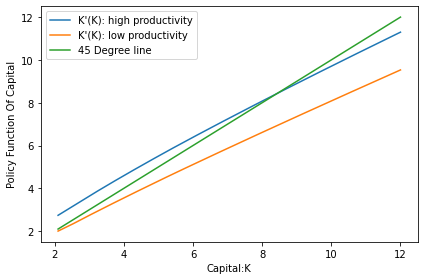

In [11]:
plt.plot(K,Kpe_1.detach(),label= r"K'(K): high productivity" )
plt.plot(K,Kpe_2.detach(),label= r"K'(K): low productivity" )
plt.plot(K,K,label= r"45 Degree line" )
plt.ylabel(r"Policy Function Of Capital")
plt.xlabel(r"Capital:K")
plt.tight_layout()
plt.legend(loc='best')
plt.savefig("Capital.pdf")
plt.show()

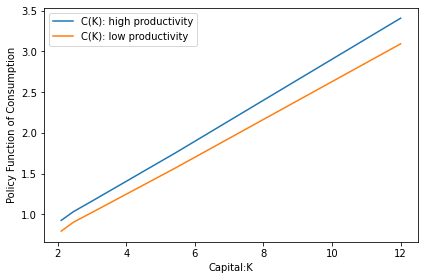

In [13]:
plt.plot(K,ce_1.detach(),label= r"C(K): high productivity" )
plt.plot(K,ce_2.detach(),label= r"C(K): low productivity" )
plt.ylabel(r"Policy Function of Consumption")
plt.xlabel(r"Capital:K")
plt.tight_layout()
plt.legend(loc='best')
plt.savefig("Consumpt.pdf")
plt.show()